## Intro

For some types of runs, athletes need to consume calories during their activity. To help them with the planning of these longer runs, we'd like to **predict how many calories they will burn for a planned run**.  On TrainingPeaks, we call "completed" runs for those which have already occurred. These typically come from someone's device like a Garmin watch. "Planned" runs are those on the calendar for the future. An example of what an athlete's calendar might look like is below.


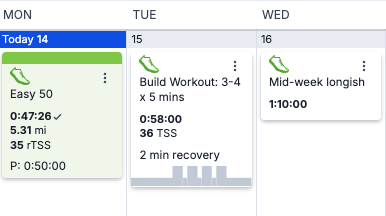

For a first version of the product, the team would like to fill in a value in the "calories" field for planned runs.

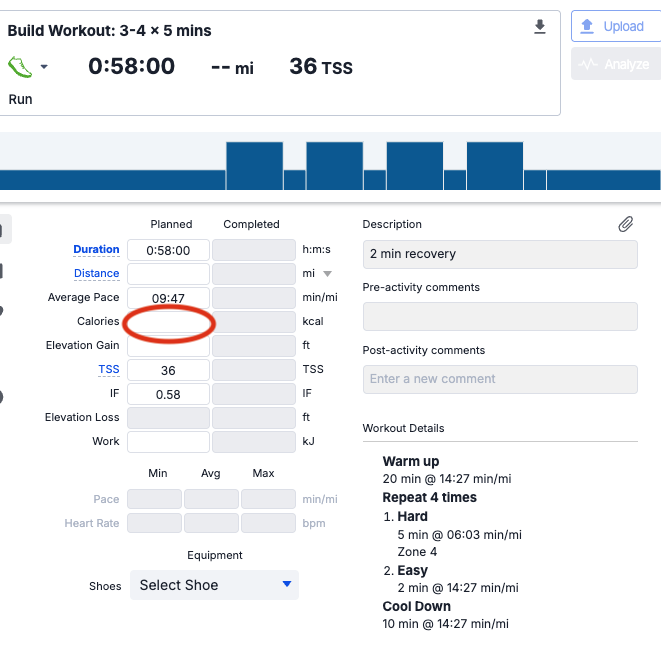

Below we provide data for completed runs. Please use this data to develop an algorithm that the product team could use to predict calories for planned workouts. We will break this out into specific steps below.

**It's OK to use AI to help with the coding. If you do, please call out where.**

Google Collab does have a memory limit. If you feel more comfortable, feel free to download the data and use an environment you're comfortable with, then upload that notebook to the Google drive.

## 0. Setup

Run the block below, as well as any additional libraries you may need. If you want to load something that isn't available, run `!pip install library_name`

In [1]:
# Modifying  data
import pandas as pd
import numpy as np
import os

# Visualization
import matplotlib.pyplot as plt

# Model data
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle

In [2]:
# Load data
!pip install -U --no-cache-dir gdown --pre
!gdown --no-cookies --fuzzy https://drive.google.com/file/d/14a3eABnxVJ3GJhQTLdpou_TsOi8Cs3cO/view?usp=sharing
data_output = "workout_data.csv"


#workout_data = pd.read_csv(data_output) # Load data in Collab


Downloading...
From: https://drive.google.com/uc?id=14a3eABnxVJ3GJhQTLdpou_TsOi8Cs3cO
To: C:\Users\kemur\Downloads\Murphy_TakeHome\workout_data.csv

  0%|          | 0.00/40.0M [00:00<?, ?B/s]
  5%|5         | 2.10M/40.0M [00:00<00:01, 19.4MB/s]
 14%|#4        | 5.77M/40.0M [00:00<00:01, 28.0MB/s]
 29%|##8       | 11.5M/40.0M [00:00<00:00, 39.0MB/s]
 43%|####3     | 17.3M/40.0M [00:00<00:00, 45.5MB/s]
 60%|######    | 24.1M/40.0M [00:00<00:00, 53.1MB/s]
 79%|#######8  | 31.5M/40.0M [00:00<00:00, 58.4MB/s]
 94%|#########4| 37.7M/40.0M [00:00<00:00, 58.3MB/s]
100%|##########| 40.0M/40.0M [00:00<00:00, 51.3MB/s]


In [3]:
from DataManager import DataManager # DataManager Class
from DataVisualizer import DataVisualizer # DataVisualizer Class
from CaloriePredictor import CaloriePredictor # CaloriePredictor Class

##  1. The plan (30 minutes)
**TASK**: Share your thought process about how you would approaching this at a high-level. Note that we have not provided you with _planned_ run data, just actual runs. Fow now, assume that predicting the calorie value with the other columns provided is sufficient.

### Plan
The goal of this project is to develop a predictive model that estimates the number of calories burned during planned workouts using data from completed ones. Since planned workout data is not provided, I would proceed under the assumption that planned workouts will have the same structure and available features as the completed runs, minus the CALORIES column. 

After confirming the objective, I would begin by loading the data. The dataset provided is large, ~500,000 entries, so I will randomly select a subset of 10% to analyze and make the assumption that selection under those specifications yields a sample representative of the overall dataset. Subsetting the data also improves processing time, which is important during model development. 

Once the data is loaded, I can begin my exploratory data analysis (EDA) to get a sense of the dataset's shape and quality. I will look at missing values and how they are distributed because that has a direct impact on how the model will handle future planned workouts. This also includes a check on athlete distribution. Most athletes in the dataset log only one or two activities, which means we cannot rely heavily on per‑athlete history for imputation at this stage.

Next, I will visualize the data in a series of histograms, which will give me an idea of expected ranges and which datasets have obvious outliers. Then I will begin cleaning the data. Using ranges from the histograms as well as domain knowledge, I will set the acceptable ranges of specific features to avoid including invalid or extreme values. For example, a heart rate should not be negative nor should the distance of a run be greater than 100km. Yes, ultra runners exist and are likely common users of the TrainingPeaks platform. However, those entries would still be considered outliers among the rest of the dataset and should not be included. Additionally, any negative or null caloric data should be dropped because it cannot help inform from neither the training nor test set side of the regression. After the data is clean, I will examine the percentage of data retention to make sure that the parameters were not too restrictive. I will then revisualize the cleaned datasets and confirm that invalid values have been removed and the data is still accurately captured.

Next I'd select a model. For this project, I would choose LightGBM because it is fast, manages large datasets well, and handles missing data effectively. It is also very scalable, so as more planned run data is received, it can be easily applied. A simpler model based only on distance, weight, and duration was considered, but it would not be practical for future applications since only ~30% of planned workouts include distance. It is important to eliminate data leakage where possible, so the data will be split into training and test sets before any transformations are applied. On the training set, weight and heart rate will be imputed. The model will be validated and feature importance will confirm which features most heavily influence the prediction.

Lastly, I will package the trained model into a prediction function, which will return calculated caloric values for hypothetical planned runs, even when some features are missing. 

## 2. Data exploration (30 minutes)

Naturally, our data is not perfect.

For example - if a run with greater than 0 distance has 0 calories, that's obviously wrong.

We don't expect you to catch every data edge case in this takehome environment, we're just looking to see how you approach this step.

Here is some additional information about the columns:

| Column | Description  |
|---------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| CALORIES                  | kCal burned on the run. This value comes from the device (e.g., Garmin). We don't know how they determine this value, but it is the variable we are looking to predict.     |
| DISTANCE_ACTUAL           | Actual distance run. Measured in meters. This value comes from the device (e.g., Garmin).  |
| DURATION_ACTUAL           | Actual time duration of the run. Measured in hours. This value comes from the device (e.g., Garmin).  |
| HRMAX  | Maximum heart rate achieved on the run in beats per minute. This value comes from the device. |
| HRAVG  | Average heart rate over the run in beats per minute. This value comes from the device.   |
| ELEVATIONAVG  | Average elevation of the run in meters. This value comes from the device. |
| ELEVATIONGAIN  | Elevation gain on the run in meters. This value comes from the device.|
| TRAININGSTRESSSCOREACTUAL | This metric quantifies how much training stress occurs on the run. You can read more details [here](https://www.trainingpeaks.com/learn/articles/running-training-stress-score-rtss-explained/) but all you need to know is that this value is a function of how hard the run was for someone based on the volume and intensity. Higher value = harder run. |
| SEX | Gender as entered by the athlete. |
| AGE  | Age in years as entered by the athlete.  |
| WEIGHT  | Weight as entered by the athlete in kilograms. |
| ATHLETE_ID   | The unique identifier for the individual.  |

**TASK**: Spend a little time exploring the data provided, cleaning it where you feel is approriate.

1. Any cleaning steps you took and why.
2. Any questions you'd ask or assumptions you'd make

### Read in Data
The first step is to read in the data in its raw form. This gives a first glance at what to expect and shows initial obvious errors. For example, 'weight' is lower case, while the other data columns are upper case. In order to keep the dataset neat and uniform upon upload, a class is defined. Now when the dataset is uploaded, the 'weight' column can be automatically read in as 'WEIGHT' to match the others. 

Large datasets can be computationally expensive to process during model training. This dataset is ~500,000 entries, so it is advantageous to analyze a subset. Since there could be existing bias in the way that the data is stored in the original .csv, e.g. sorted by distance, athlete number, athlete age, etc., the entries are randomized based on a specific random_state. This allows for the assumption that the data subset is representative of the overall sample, while also always returning the same entries for reproducibility.

In [4]:
# Checkout the raw data
raw_workout_data = pd.read_csv(data_output)
raw_workout_data.head()

,CALORIES,DISTANCE_ACTUAL,DURATION_ACTUAL,HRMAX,HRAVG,ELEVATIONAVG,ELEVATIONGAIN,TRAININGSTRESSSCOREACTUAL,SEX,AGE,weight,ATHLETE_ID
0,386,4180.229980,0.535753,184.0,139.0,170.501450,252.0,116.17,m,23.0,NaN,123547975
1,373,5016.040039,0.477307,158.0,140.0,206.775726,49.0,31.92,m,45.0,NaN,814250454
2,728,11278.089844,0.776566,186.0,162.0,203.204041,179.0,72.46,m,44.0,63.503007,261358113
3,411,8252.400391,0.701063,162.0,148.0,82.000000,58.0,632.56,f,34.0,51.500000,177033195
4,572,9261.129883,0.753228,160.0,144.0,NaN,NaN,173.67,m,41.0,71.500000,93067954


### DataManager Class
The DataManager class handles data loading, cleaning, and other basic operations. It loads the data in the expected format, identifies missing data, provides insight into number of activities per athlete, and cleans the data of invalid or outlier values. Cursor was used to take individually written functions and role them into a neatly organized class.

In [5]:
# Read in the data through the defined class, which does base level dataframe management upon upload
dataManagerClass_full = DataManager(data_output)
workout_data_full = dataManagerClass_full.load_data()
workout_data_full.head() # View first 5 entries

Loading data...
Using all 500,878 records


,CALORIES,DISTANCE_ACTUAL,DURATION_ACTUAL,HRMAX,HRAVG,ELEVATIONAVG,ELEVATIONGAIN,TRAININGSTRESSSCOREACTUAL,SEX,AGE,WEIGHT,ATHLETE_ID
0,386,4180.229980,0.535753,184.0,139.0,170.501450,252.0,116.17,m,23.0,NaN,123547975
1,373,5016.040039,0.477307,158.0,140.0,206.775726,49.0,31.92,m,45.0,NaN,814250454
2,728,11278.089844,0.776566,186.0,162.0,203.204041,179.0,72.46,m,44.0,63.503007,261358113
3,411,8252.400391,0.701063,162.0,148.0,82.000000,58.0,632.56,f,34.0,51.500000,177033195
4,572,9261.129883,0.753228,160.0,144.0,NaN,NaN,173.67,m,41.0,71.500000,93067954


In [6]:
# Create a class for the data subset 
DMCS = DataManager(data_output, sample_size=50000) # Data Manager Class Subset
workout_data = DMCS.load_data()
workout_data.head()

Loading data...
Randomly sampled 50,000 records


,CALORIES,DISTANCE_ACTUAL,DURATION_ACTUAL,HRMAX,HRAVG,ELEVATIONAVG,ELEVATIONGAIN,TRAININGSTRESSSCOREACTUAL,SEX,AGE,WEIGHT,ATHLETE_ID
0,323,4763.000000,0.508507,174.0,160.0,31.0,148.0,58.00,f,60.0,63.900000,520393627
1,922,14501.870117,1.209633,189.0,158.0,99.0,167.0,215.21,f,33.0,NaN,710729648
2,832,11017.059570,1.119398,182.0,145.0,2563.0,40.0,101.44,m,43.0,80.598999,995130398
3,1804,23691.000000,3.141445,180.0,140.0,446.0,822.0,124.00,m,45.0,65.000000,669619998
4,884,12060.299805,1.190513,132.0,120.0,727.0,81.0,87.10,m,55.0,82.000000,203868311


In [7]:
# Analyze the missing data
# Important to understand the scale and distribution of missing values as this will inform the need to impute
DMCS.analyze_missing_data()


++ Missing Data Analysis ++
CALORIES                 :      0 missing (  0.0%)
DURATION_ACTUAL          :      4 missing (  0.0%)
DISTANCE_ACTUAL          :    427 missing (  0.9%)
HRMAX                    :  2,241 missing (  4.5%)
HRAVG                    :  2,211 missing (  4.4%)
ELEVATIONAVG             :  6,844 missing ( 13.7%)
ELEVATIONGAIN            :  6,671 missing ( 13.3%)
TRAININGSTRESSSCOREACTUAL:    684 missing (  1.4%)
AGE                      :      0 missing (  0.0%)
WEIGHT                   : 18,369 missing ( 36.7%)
SEX                      :    627 missing (  1.3%)


{'CALORIES': {'count': np.int64(0), 'percentage': np.float64(0.0)},
 'DURATION_ACTUAL': {'count': np.int64(4), 'percentage': np.float64(0.008)},
 'DISTANCE_ACTUAL': {'count': np.int64(427),
  'percentage': np.float64(0.8540000000000001)},
 'HRMAX': {'count': np.int64(2241), 'percentage': np.float64(4.482)},
 'HRAVG': {'count': np.int64(2211),
  'percentage': np.float64(4.422000000000001)},
 'ELEVATIONAVG': {'count': np.int64(6844), 'percentage': np.float64(13.688)},
 'ELEVATIONGAIN': {'count': np.int64(6671), 'percentage': np.float64(13.342)},
 'TRAININGSTRESSSCOREACTUAL': {'count': np.int64(684),
  'percentage': np.float64(1.3679999999999999)},
 'AGE': {'count': np.int64(0), 'percentage': np.float64(0.0)},
 'WEIGHT': {'count': np.int64(18369), 'percentage': np.float64(36.738)},
 'SEX': {'count': np.int64(627), 'percentage': np.float64(1.254)}}

In [8]:
# Analyze the athlete distribution
# For this dataset, most of the athletes are unique so there's no benefit in performing athlete level statistics
DMCS.analyze_athlete_distribution()


++ Activities by Athlete ++
Total athletes: 47,458
Total activities: 50,000
Average activities per athlete: 1.1

++ Athletes by Activity Count ++
  1-5 activities : 47,455 athletes (100.0%)
  6-15 activities:      3 athletes (  0.0%)
  16-30 activities:      0 athletes (  0.0%)
  31-50 activities:      0 athletes (  0.0%)
  50+ activities :      0 athletes (  0.0%)


### Visualize Data
It is important to visualize the data before and after cleaning it. Visualizing before provides a baseline understanding of raw data distribution and offers insight into where quality issues may lie. It can also be used to inform appropriate cutoff values for different features. Post-cleaning visualization is important as well because it confirms that the cleaning worked as intended. It also shows that there is still significant data retention and not too much was removed. Lastly, it showcases the characteristics of the final dataset.

In [9]:
# Establish the data visualizer class using the data manager class with subsetted data
# This is acceptable since the randomized subset dataset is assumed to be representative of the dataset as a whole
DV = DataVisualizer(DMCS)

Creating pre-cleaning visualizations...


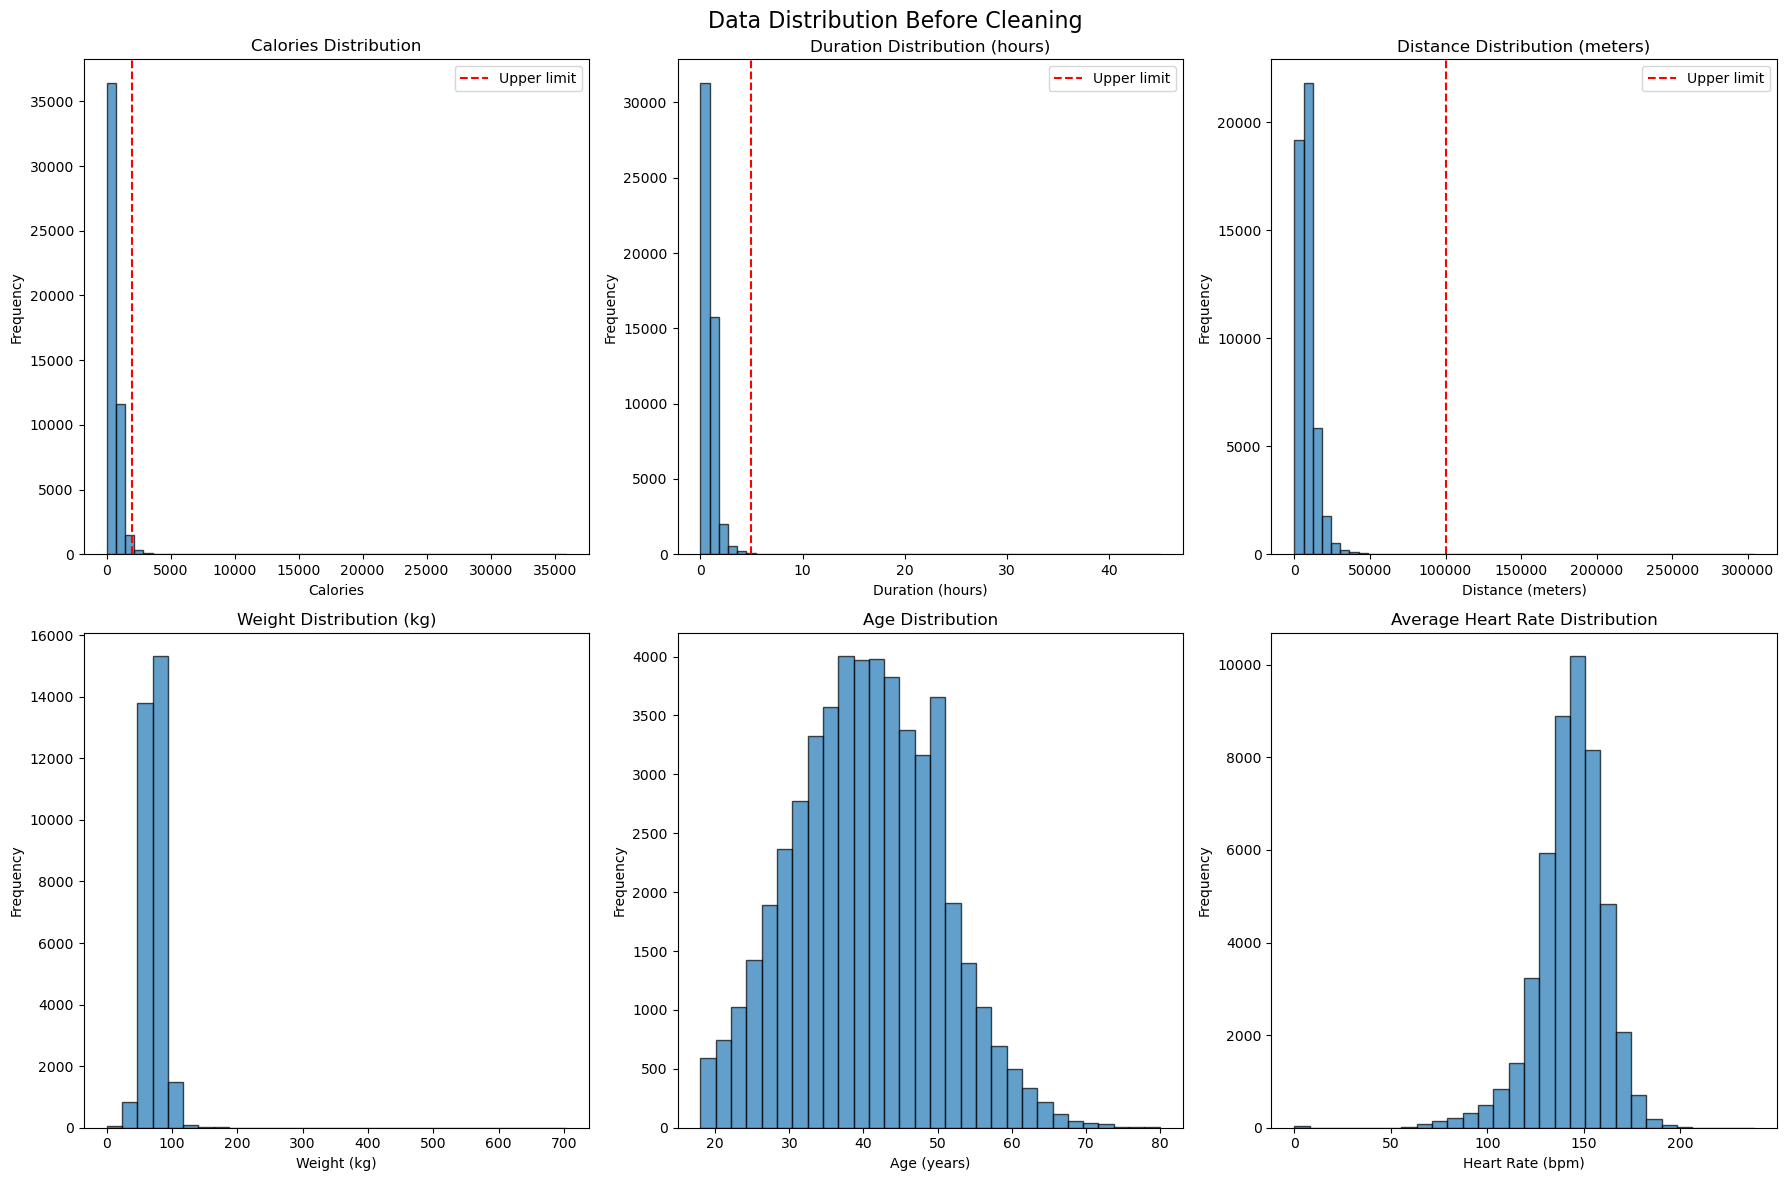


++ Activity Metadata Before Cleaning ++
Calories range: 0 - 35875
Duration range: 0.000 - 45.000 hours
Distance range: 0 - 303683 meters


In [10]:
# Visualize the raw data
# Important to see the distribution before any cleaning to help focus in on what acceptable limits are and to get an idea of how many outliers there will be
DV.visualize_raw_data()

### Cleaning the data
It is important to clean the data because some of the values in the current dataset are physically impossible or they are so extreme they'd skew the data. For example, we don't want entries with a negative heart rate, negative age, negative weight because those are impossible.
We also do not want entries with negative or null calorie data because it cannot contribute to supervised learning. Industry knowledge and the pre-cleaned plots were used to help set the ranges for what was considered a valid value. It was assumed that the missing data was at random and not systematic. It was also assumed that although we are looking at data from individuals, relationships between different features remained constant across all athletes.

In [11]:
# Clean the data
DMCS.clean_data()


Cleaning data...

++ Summary of Cleaned Dataset ++
Records flagged for invalid calories (< 5 or > 2000): 906
Records flagged for invalid duration (< 1 minute or > 5 hours): 495
Records flagged for invalid distance (< 100 m or > 100 km): 352
Records flagged for invalid average heart rate (< 30 or > 250): 41
Records flagged for invalid heart rate max (< 30 or > 250): 40
Records flagged for invalid age (< 18 or > 100): 0
Records flagged for invalid weight (< 20 kgs or > 200 kgs): 45
Total rows removed: 1,242
Final rows after cleaning: 48,758
Data retention: 97.5%


,CALORIES,DISTANCE_ACTUAL,DURATION_ACTUAL,HRMAX,HRAVG,ELEVATIONAVG,ELEVATIONGAIN,TRAININGSTRESSSCOREACTUAL,SEX,AGE,WEIGHT,ATHLETE_ID
0,323,4763.000000,0.508507,174.0,160.0,31.0,148.0,58.00,f,60.0,63.900000,520393627
1,922,14501.870117,1.209633,189.0,158.0,99.0,167.0,215.21,f,33.0,NaN,710729648
2,832,11017.059570,1.119398,182.0,145.0,2563.0,40.0,101.44,m,43.0,80.598999,995130398
3,1804,23691.000000,3.141445,180.0,140.0,446.0,822.0,124.00,m,45.0,65.000000,669619998
4,884,12060.299805,1.190513,132.0,120.0,727.0,81.0,87.10,m,55.0,82.000000,203868311
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,595,6305.470215,1.057500,178.0,149.0,NaN,NaN,44.73,f,46.0,76.540000,705109087
49996,1003,21307.039062,1.750299,166.0,148.0,2198.0,9.0,232.02,m,42.0,75.000000,248434963
49997,762,14143.990234,1.377793,167.0,158.0,729.0,52.0,110.08,f,40.0,NaN,299004802
49998,626,9007.559570,0.917207,149.0,134.0,1078.0,26.0,67.49,m,21.0,NaN,953822413



Creating post-cleaning visualizations...


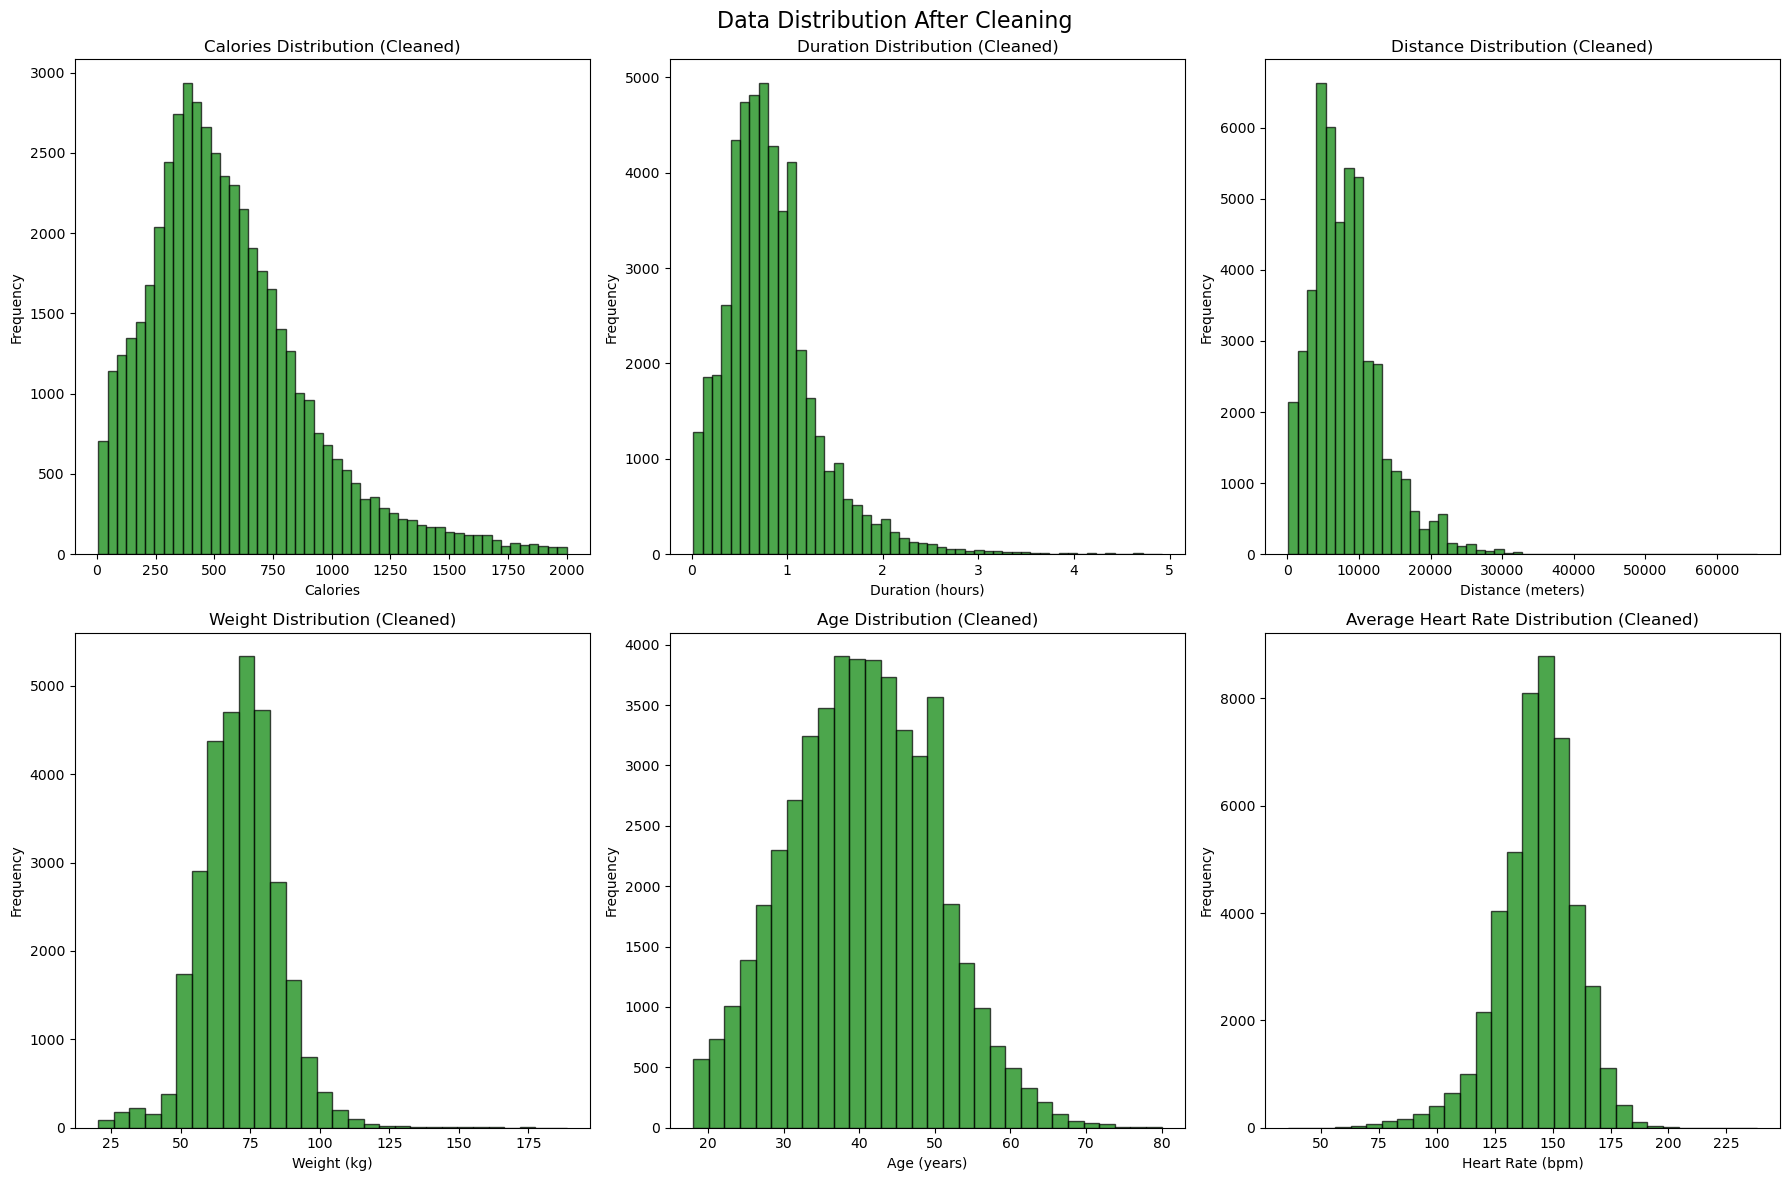


++ Activity Metadata After Cleaning ++
Calories range: 5 - 2000
Duration range: 0.017 - 4.917 hours
Distance range: 102 - 65542 meters


In [12]:
# Update the dataset in the visualization class, so it can be plotted again to show differences after cleaning
DV.update_data()

# Visualize the clean data
DV.visualize_cleaned_data()

## 3. Modeling (2 hours)

The next step is determine what the product team should build in the MVP version of predicted run calories. We know you could spend days working here, please resist. We will ask you to comment on what you would do with more time in the next section.


**TASK**: Come up with an approach for predicting calories in the data provided. Provide in comments or Markdown text boxes your thought process and assumptions.

### Model Selection
I chose to use LightGBM to build the model because of its ability to manage large datasets and to handle missing values. It also has a relatively quick processing time. Additionally, it has a built in feature importance function that is useful when determining which data is influential and what should be imputed rather than removed. Lastly, LightGBM scales nicely, so it would be easily adapted to larger datasets of planned runs.

### CaloriePredictor
CaloriePredictor is a class that manages features, determines their importance, and then uses a training dataset to build a model and a test set to determine its validity. To start, this class uses existing columns to derive additional useful features since sometimes ratios can be more influential than their separate parts. After, the dataset is split into a training and test dataset so that the test set can stay completely unaffected by any transformations performed. Doing this split prior to data manipulation is crucial in preventing data leakage. Otherwise, the model is at risk of overly optimistic performance and it would likely be less successful when deployed in real world scenarios. The training dataset then used demographic features to inform imputation on other key features. The training set was then run through the regressor and a model was generated. MAE, R squared, and CV MAE statistics were calculated and the model was then determined to be a success or in need of more modifications. The model was then pickled so that it could be more easily distributed to others. Cursor wrote the prediction function, which applied the developed model. 

In [13]:
# Read in updated dataset
CP = CaloriePredictor(DMCS)

In [14]:
# Create features and train model
CP.create_features()
mae, r2, cv_mae = CP.train_model()


Creating features...
Created 13 features

Training model...
Handling missing values using training data only...


C:\Users\kemur\Downloads\Murphy_TakeHome\CaloriePredictor.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['PACE'] = self.df['DURATION_ACTUAL'] / (self.df['DISTANCE_ACTUAL'] / 1000)  # hours per km
C:\Users\kemur\Downloads\Murphy_TakeHome\CaloriePredictor.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['SPEED'] = (self.df['DISTANCE_ACTUAL'] / 1000) / self.df['DURATION_ACTUAL']  # km per hour
C:\Users\kemur\Downloads\Murphy_TakeHome\CaloriePredictor.py:31: SettingWithCopyWarning: 
A 


Model Performance (with demographic imputation):
  MAE: 58.8 calories
  R²: 0.924
  CV MAE: 59.0 ± 0.6 calories



Feature Importance:
  WEIGHT              : 548.000
  DURATION_ACTUAL     : 453.000
  DISTANCE_ACTUAL     : 386.000
  HRAVG               : 346.000
  PACE                : 216.000
  ELEVATIONGAIN       : 212.000
  TRAININGSTRESSSCOREACTUAL: 200.000
  ELEVATIONAVG        : 171.000
  INTENSITY_RATIO     : 166.000
  HRMAX               : 153.000
  SPEED               : 91.000
  AGE                 : 58.000
  SEX_ENCODED         : 0.000


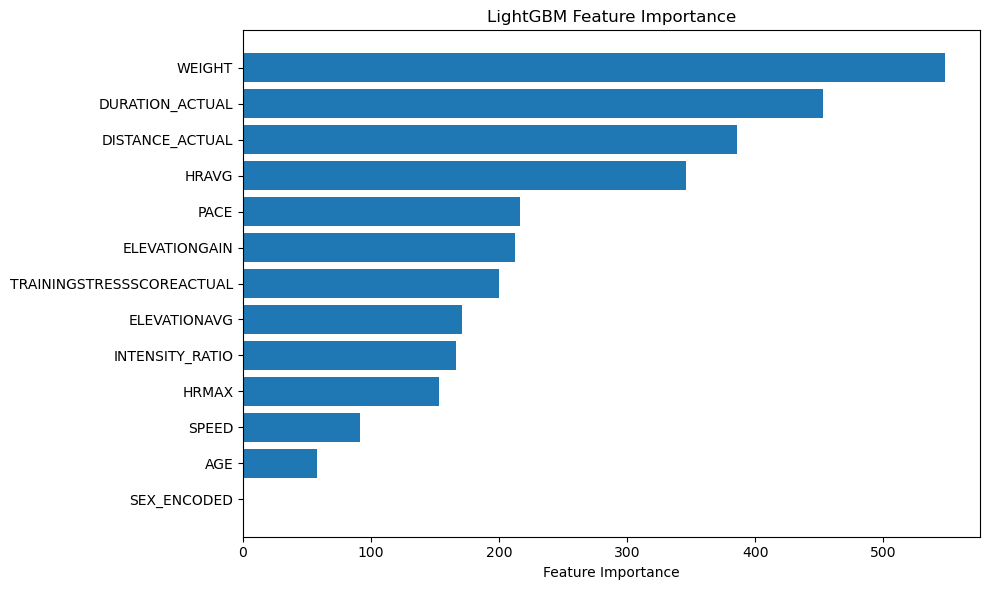

,feature,importance
8,WEIGHT,548
0,DURATION_ACTUAL,453
1,DISTANCE_ACTUAL,386
3,HRAVG,346
10,PACE,216
5,ELEVATIONGAIN,212
6,TRAININGSTRESSSCOREACTUAL,200
4,ELEVATIONAVG,171
12,INTENSITY_RATIO,166
2,HRMAX,153


In [15]:
# Show which features are most important
CP.show_feature_importance()

In [16]:
# Save the model
calorie_model = CP.save_model()

In [17]:
# Create a prediction function to apply model to dataset
prediction_function = CP.create_prediction_function()

## 4. Planned runs (10 minutes)

When you look at the planned run data, you see that most values are not available. Age, gender and weight all follow the same distribution as the actual run data. But for specific workouts, the only consistently available value is duration. All runs have a value for duration, 30% have a value for distance (and therefore average speed) as well. 10% have a value for TrainingStressScore.

TASK: Explain how would take the above information about planned run data into account?

Planned run data is sparse, so the model must remain reliable even with minimal inputs. Duration is the only field consistently available, so the baseline path must always produce a calorie estimate from duration alone. When distance is present, I would add pace and speed. If Training Stress Score is available, I would include it as well. This ensures reliable predictions for all planned workouts, while still leveraging additional data when available. If time allowed, I would create a separate duration-only baseline model and compare its performance against the full model when only duration is available. 

Because age, sex, and weight distributions match the completed run data, I can impute those variables for planned workouts using demographic medians from the actual runs. LightGBM’s ability to handle missing values directly makes it well suited for this scenario, so that would still be the model of choice.

In practice, I would train on the full feature set but validate performance under restricted inputs to ensure the model performs at different tiers of data availability.

In [21]:
# Analysis roll up
# Clean packaged function that could be delivered as a click and go, if given the filepath to the data source and potentially a subset sample size
# Used Cursor to take workflow and package neatly into one function
def run_complete_analysis(filepath, sample_size=None):

    # Initialize components
    data_manager = DataManager(filepath, sample_size)
    
    # Load and analyze data
    data_manager.load_data()
    data_manager.analyze_missing_data()
    data_manager.analyze_athlete_distribution()
    
    # Visualize raw data
    visualizer = DataVisualizer(data_manager)
    visualizer.visualize_raw_data()
    
    # Clean data
    data_manager.clean_data()
    visualizer.update_data()
    predictor = CaloriePredictor(data_manager)
    predictor.update_data()
    
    # Visualize cleaned data
    visualizer.visualize_cleaned_data()
    
    # Create features and train model
    predictor.create_features()
    mae, r2, cv_mae = predictor.train_model()
    
    # Show results
    predictor.show_feature_importance()
    
    # Save model
    model_file = predictor.save_model()
    
    # Create prediction function and examples
    predict_func = predictor.create_prediction_function()
    
    print("\nExample Predictions:")
    print(f"  30 min run: {predict_func(0.5):.0f} calories")
    print(f"  1 hour run: {predict_func(1.0):.0f} calories")
    print(f"  2 hour run: {predict_func(2.0):.0f} calories")
    
    print(f"\nAnalysis complete! Model saved to {model_file}")
    
    return {
        'data_manager': data_manager,
        'visualizer': visualizer,
        'predictor': predictor,
        'mae': mae,
        'r2': r2,
        'cv_mae': cv_mae,
        'predict_function': predict_func,
        'model_file': model_file
    }

=== MODULAR CALORIE PREDICTION ANALYSIS ===
Loading data...
Randomly sampled 50,000 records

++ Missing Data Analysis ++
CALORIES                 :      0 missing (  0.0%)
DURATION_ACTUAL          :      4 missing (  0.0%)
DISTANCE_ACTUAL          :    427 missing (  0.9%)
HRMAX                    :  2,241 missing (  4.5%)
HRAVG                    :  2,211 missing (  4.4%)
ELEVATIONAVG             :  6,844 missing ( 13.7%)
ELEVATIONGAIN            :  6,671 missing ( 13.3%)
TRAININGSTRESSSCOREACTUAL:    684 missing (  1.4%)
AGE                      :      0 missing (  0.0%)
WEIGHT                   : 18,369 missing ( 36.7%)
SEX                      :    627 missing (  1.3%)

++ Activities by Athlete ++
Total athletes: 47,458
Total activities: 50,000
Average activities per athlete: 1.1

++ Athletes by Activity Count ++
  1-5 activities : 47,455 athletes (100.0%)
  6-15 activities:      3 athletes (  0.0%)
  16-30 activities:      0 athletes (  0.0%)
  31-50 activities:      0 athletes ( 

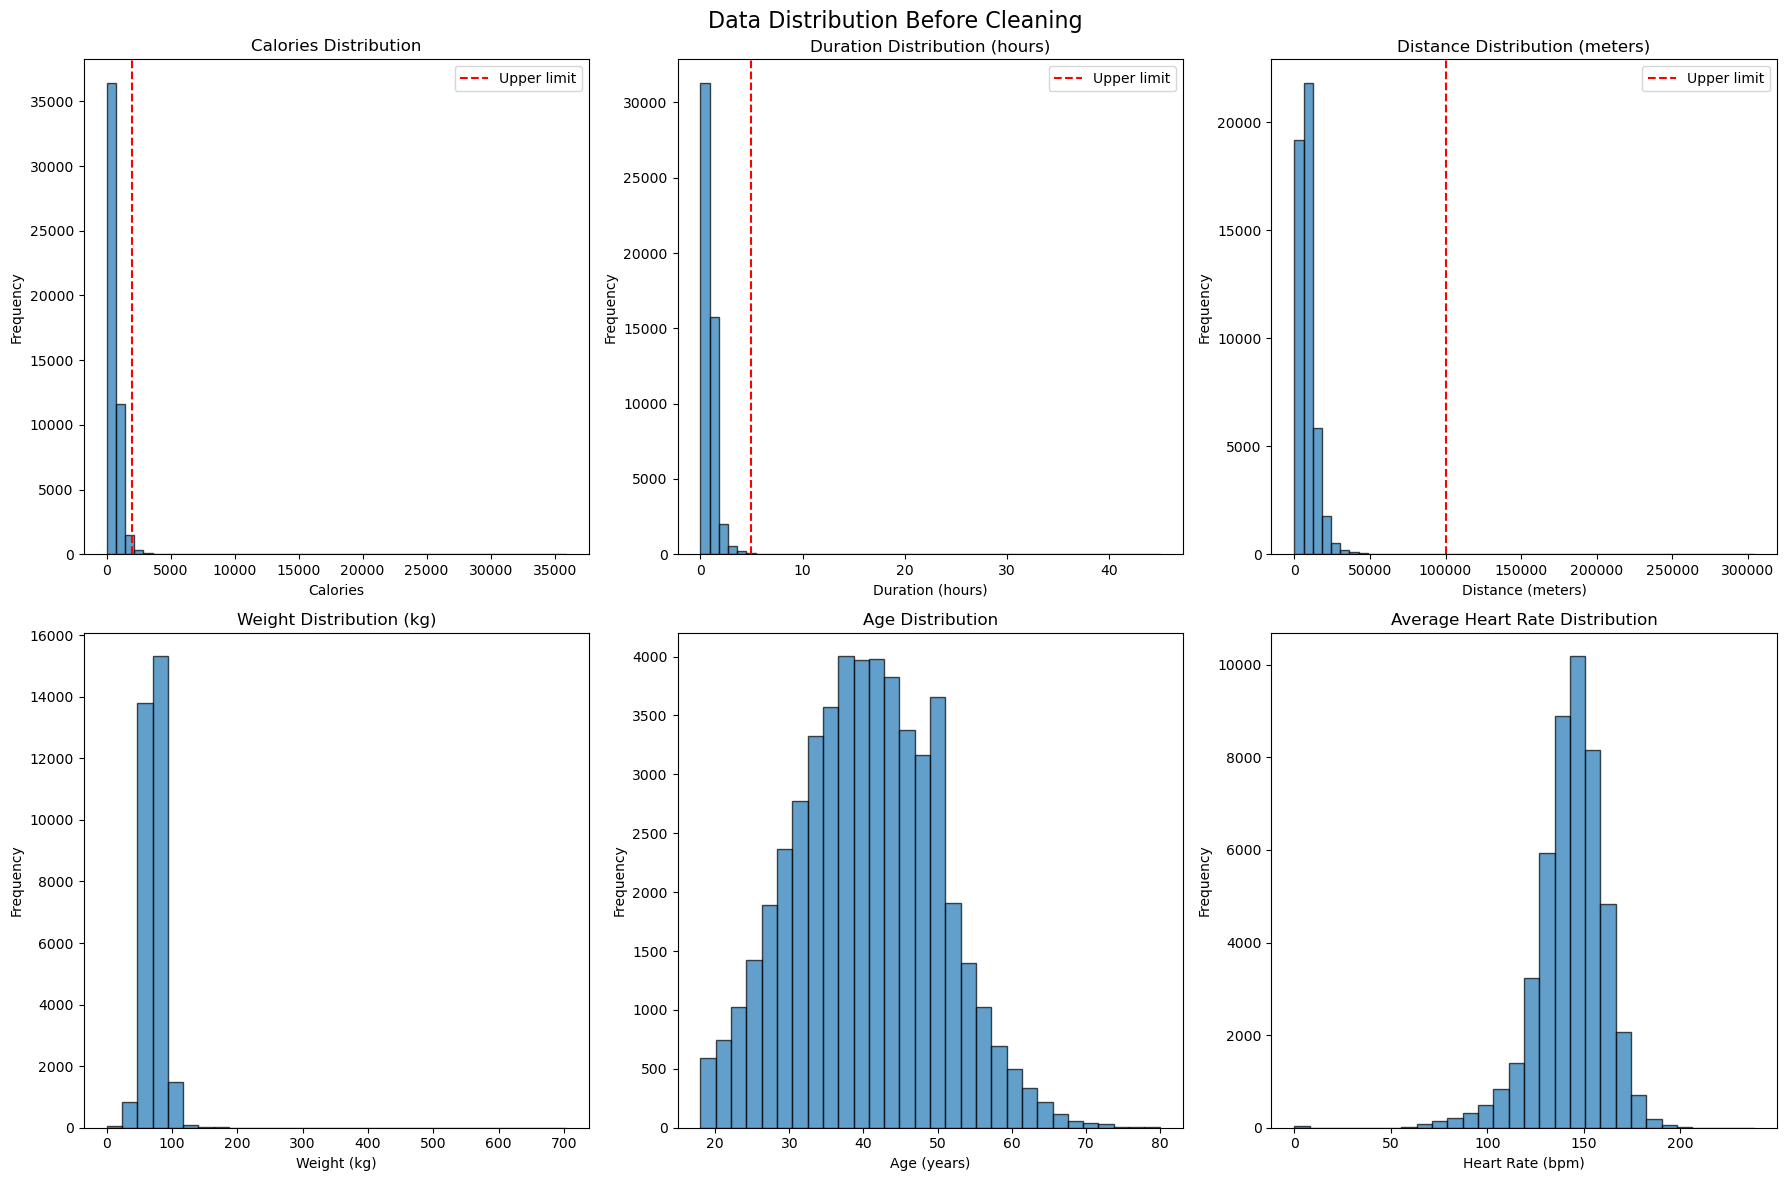


++ Activity Metadata Before Cleaning ++
Calories range: 0 - 35875
Duration range: 0.000 - 45.000 hours
Distance range: 0 - 303683 meters

Cleaning data...

++ Summary of Cleaned Dataset ++
Records flagged for invalid calories (< 5 or > 2000): 906
Records flagged for invalid duration (< 1 minute or > 5 hours): 495
Records flagged for invalid distance (< 100 m or > 100 km): 352
Records flagged for invalid average heart rate (< 30 or > 250): 41
Records flagged for invalid heart rate max (< 30 or > 250): 40
Records flagged for invalid age (< 18 or > 100): 0
Records flagged for invalid weight (< 20 kgs or > 200 kgs): 45
Total rows removed: 1,242
Final rows after cleaning: 48,758
Data retention: 97.5%

Creating post-cleaning visualizations...


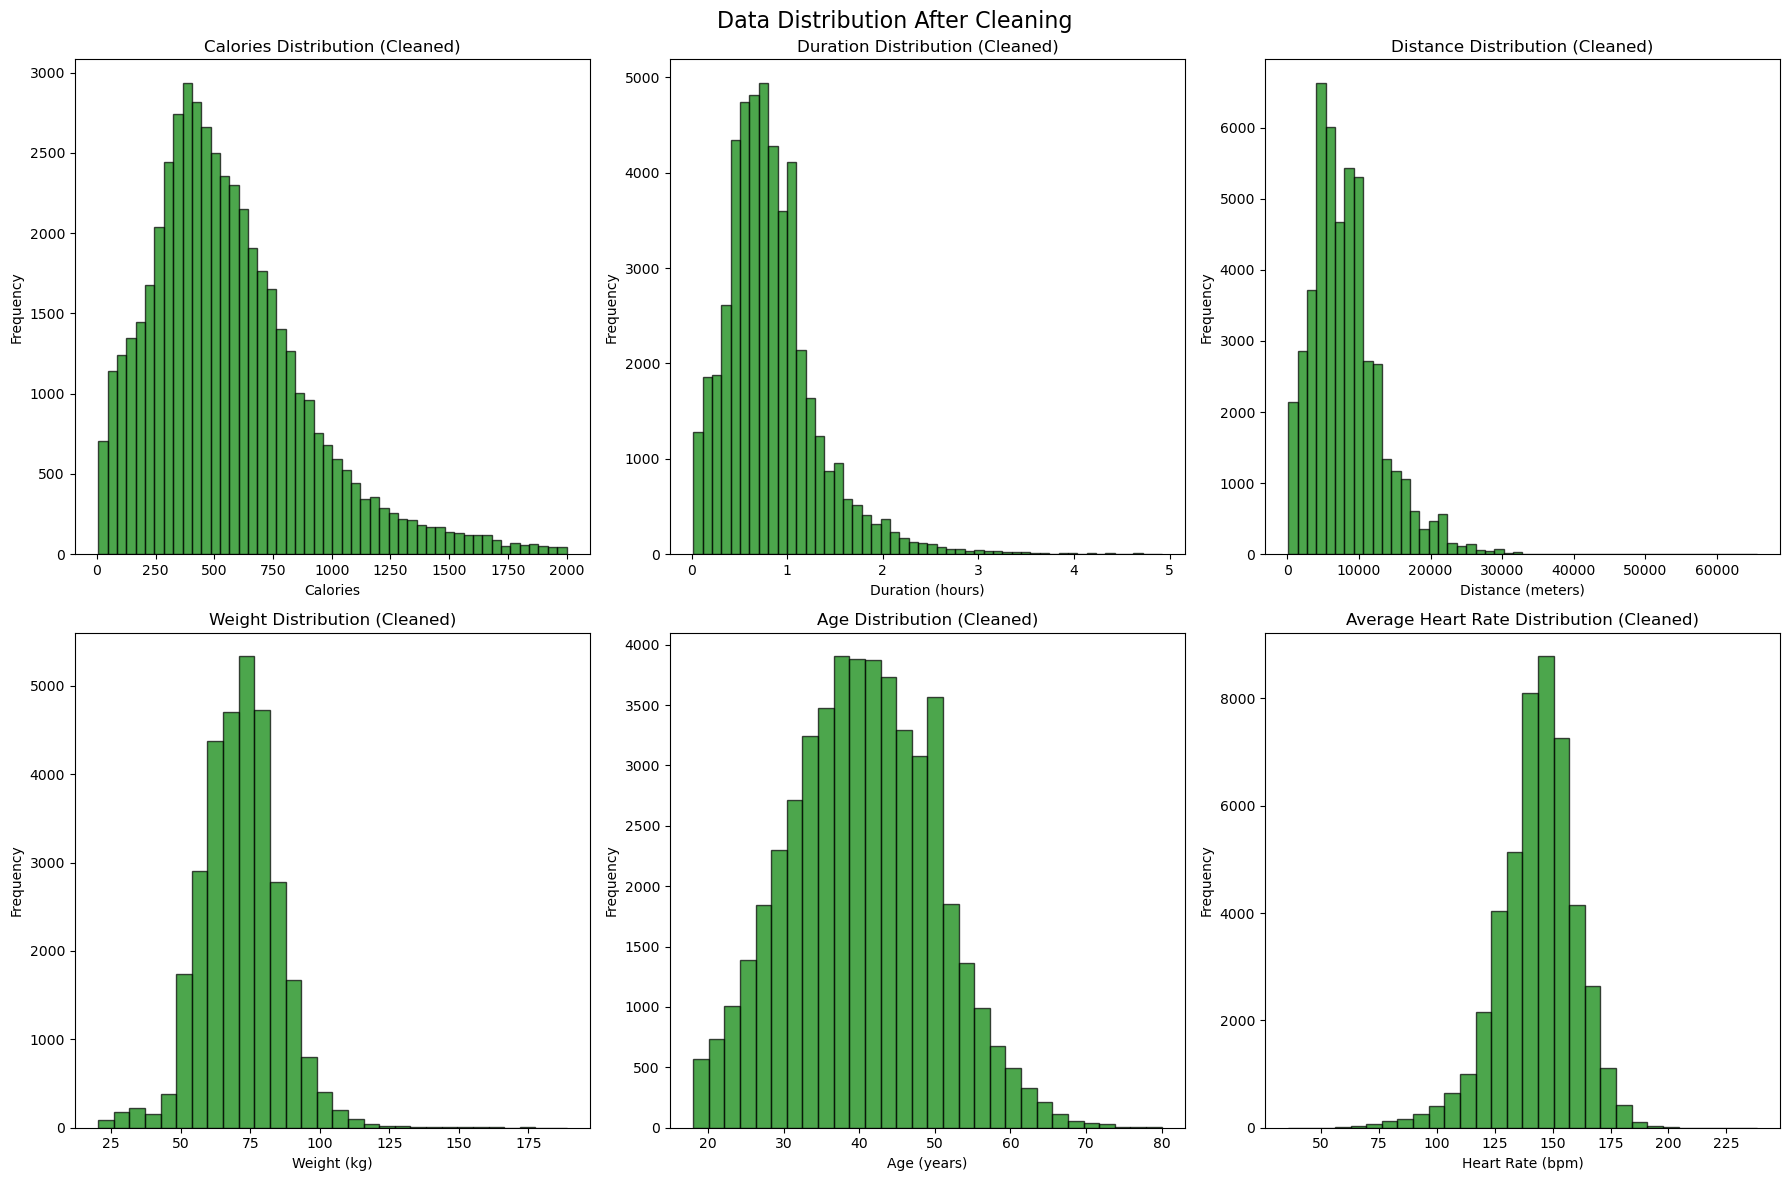


++ Activity Metadata After Cleaning ++
Calories range: 5 - 2000
Duration range: 0.017 - 4.917 hours
Distance range: 102 - 65542 meters

Creating features...
Created 13 features

Training model...
Handling missing values using training data only...

Model Performance (with demographic imputation):
  MAE: 58.8 calories
  R²: 0.924
  CV MAE: 59.0 ± 0.6 calories

Feature Importance:
  WEIGHT              : 548.000
  DURATION_ACTUAL     : 453.000
  DISTANCE_ACTUAL     : 386.000
  HRAVG               : 346.000
  PACE                : 216.000
  ELEVATIONGAIN       : 212.000
  TRAININGSTRESSSCOREACTUAL: 200.000
  ELEVATIONAVG        : 171.000
  INTENSITY_RATIO     : 166.000
  HRMAX               : 153.000
  SPEED               : 91.000
  AGE                 : 58.000
  SEX_ENCODED         : 0.000


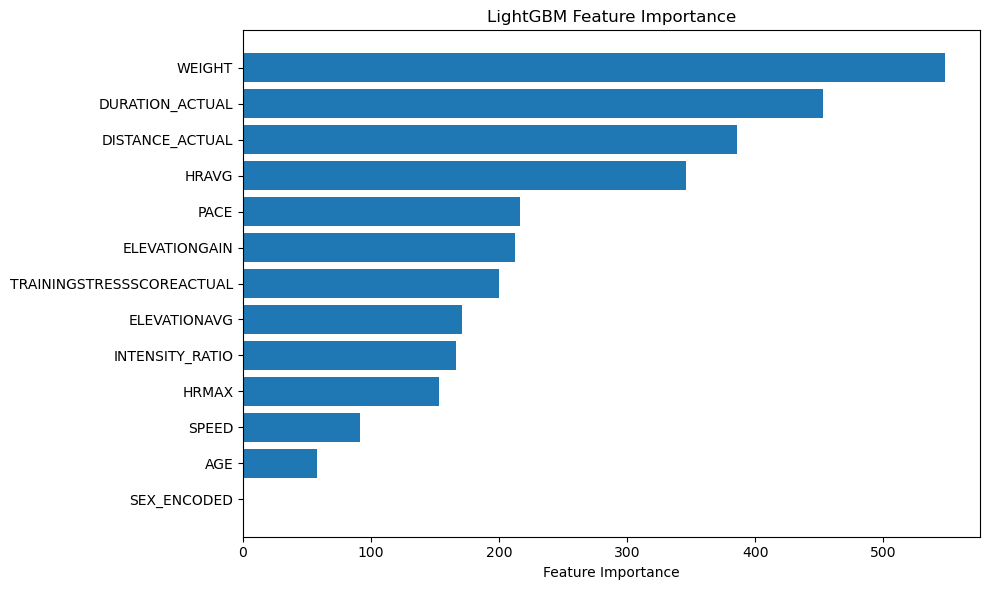


Example Predictions:
  30 min run: 410 calories
  1 hour run: 705 calories
  2 hour run: 1223 calories

Analysis complete! Model saved to calorie_prediction_model.pkl


In [22]:
# Example of how to run the workflow from start to finish given the dataset
results = run_complete_analysis(data_output, sample_size=50000)

## 5. With more time (20 minutes)

**TASK**: If anything, what would you look into/ do with more time?


(Answer goes here)

If I had more time to extend this project, there are several areas I would explore.

First, I would build a tiered athlete system. Athletes could be grouped by the number of activities they have logged (for example: 0–5, 5–20, 20–50, 50+). Those with fewer activities would be modeled with more generalized features and imputation strategies, while athletes with richer histories could benefit from more personalized imputations and model sophistication. For higher‑activity athletes, I would also look into incorporating trends across their training history to see if training load and recovery status influence caloric expenditure.

Second, I would incorporate environmental and contextual factors such as weather and surface type. While some of this effort may already be reflected indirectly in training stress scores, conditions like high heat, humidity, or running on trails versus roads can significantly change the energy demands of a workout. Including these factors could make calorie predictions more realistic and athlete‑specific.

Finally, I would implement a monitoring system for schema drift and data quality. Planned workout data can evolve over time in structure and completeness, and automated checks would ensure the pipeline continues to deliver robust and accurate predictions as new data comes in.